1. взять любой набор данных для бинарной классификации 
2. сделать feature engineering

In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import itertools

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Abstract: The Skin Segmentation dataset is constructed over B, G, R color space. 
# Skin and Nonskin dataset is generated using skin textures from face images of diversity of age, gender, and race people.
df = pd.read_table('Skin_NonSkin.txt', sep='\t')

# Заменим 2 на 0. То есть это не кожа
df.loc[(df.skin == 2), "skin"] = 0
df["skin"]=df["skin"].astype(int)

df.skin.value_counts()

0    194198
1     50859
Name: skin, dtype: int64

In [3]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class NumberNorm(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        max_value = X[self.key].max()
        min_value = X[self.key].min()
        result[self.key] = (X[self.key] - min_value) / (max_value - min_value)
        
        return result[[self.key]]


In [4]:
continuous_columns = ['B', 'G', 'R']

In [5]:
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
#                 ('norm', NumberNorm(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [6]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

3. обучить любой классификатор (какой вам нравится)

In [7]:
# Теперь у нас есть пайплайн, который готовит признаки для моделирования.
# Добавим модель

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [9]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['skin'], test_size=0.1, random_state=42)

In [10]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('B',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B'))])),
                                                ('G',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='G'))])),
                                                ('R',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='R'))]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [11]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

In [12]:
df_up = pd.DataFrame({'preds':preds.tolist(), 'Y':y_test.tolist()})
df_up_sort = df_up.sort_values('Y', ascending=True)
df_up_sort.head(5)

,preds,Y
0,0.0,0
15411,0.0,0
15410,0.0,0
15409,0.0,0
15408,0.0,0


In [13]:
 from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.561333, F-Score=0.999, Precision=0.999, Recall=1.000


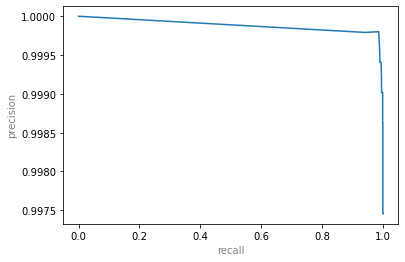

In [15]:
# plt.plot(precision, recall)
plt.plot(recall, precision)
plt.xlabel('recall', color='gray')
plt.ylabel('precision',color='gray')
plt.show()

4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [16]:
df_P = df[df['skin'] == 1].sample(frac=0.25)
ind_P = df_P.index.tolist()

5. применить random negative sampling для построения классификатора в новых условиях

In [17]:
df['y'] = 0
df.loc[ind_P,'y'] = 1

In [18]:
df.y.value_counts()

0    232342
1     12715
Name: y, dtype: int64

In [19]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['y'], random_state=0)

In [20]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('B',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B'))])),
                                                ('G',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='G'))])),
                                                ('R',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='R'))]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [21]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.        , 0.21666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.990000, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-22-010bf5497cf3>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Результаты очень слабые. Попробуем увеличить позитивную обучающую выборку с 0.25 до 0.5

In [23]:
df_P = df[df['skin'] == 1].sample(frac=0.5)
ind_P = df_P.index.tolist()
df['y'] = 0
df.loc[ind_P,'y'] = 1

In [24]:
df.y.value_counts()

0    219627
1     25430
Name: y, dtype: int64

In [25]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['y'], random_state=0)
#обучим наш пайплайн
pipeline.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
# preds[:10]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.040417, F-Score=0.657, Precision=0.495, Recall=0.977


In [26]:
Значительно веселее, но точность все таки низкая. Еще увеличим долю известных позитивов до 0.75

SyntaxError: invalid syntax (<ipython-input-26-3c1f287e255c>, line 1)

In [ ]:
df_P = df[df['skin'] == 1].sample(frac=0.75)
ind_P = df_P.index.tolist()
df['y'] = 0
df.loc[ind_P,'y'] = 1

In [ ]:
df.y.value_counts()

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['y'], random_state=0)
#обучим наш пайплайн
pipeline.fit(X_train, y_train)
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
# preds[:10]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Это уже выглядит хорошо